# Fruit classifier - InceptionV3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import os

import pandas as pd
import numpy as np

# Image loading and augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Source network
from tensorflow.keras.applications import inception_v3, InceptionV3

# Target network's classifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Input, InputLayer, Dropout

# training 
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
# evaluation
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import models

import time

%matplotlib inline

# Prepare sample data for feature extractor and classifier modelling

ImageDataGenerator used to load images into memory

```

In [ ]:
img_height = img_width = 100 
channels = 3

In [ ]:
# prepare labels, used in testing
labels = [ 'Apple Braeburn', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit',
          'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow',
          'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig',
          'Ginger Root', 'Granadilla', 'Grape Blue', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi' ]      

In [ ]:
n_train_set = 500     
n_val_set = 170 

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=0.4,
    # horizontal_flip=True,
    preprocessing_function=inception_v3.preprocess_input) 

X_train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/data/fruits-360/Training40',
                                                target_size=(img_height, img_width),
                                                batch_size=32, shuffle=False)

X_train, y_train = next(X_train_gen)

Found 20369 images belonging to 40 classes.


In [ ]:
X_train.shape, y_train.shape

((32, 100, 100, 3), (32, 40))

In [ ]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=0.4,
    # horizontal_flip=True,
    preprocessing_function=inception_v3.preprocess_input) 

X_val_gen = val_datagen.flow_from_directory('/content/drive/MyDrive/data/fruits-360/Validation40',
                                                target_size=(img_height, img_width),
                                                batch_size=32, shuffle=False)

X_val, y_val = next(X_val_gen)

Found 3422 images belonging to 40 classes.


In [ ]:
X_val.shape, y_val.shape

((32, 100, 100, 3), (32, 40))

# Prepare Feature Extractor component

In [ ]:
model_featurizer = inception_v3.InceptionV3(input_shape=(img_height, img_width, channels),
                                           include_top=False) # exclude classifier

# Prepare Classifier component

In [ ]:
sample_batch_train = X_train
sample_batch_val = X_val

featOutput_train = model_featurizer.predict(sample_batch_train)
featOutput_val = model_featurizer.predict(sample_batch_val)

featOutput_train.shape, featOutput_val.shape

((32, 1, 1, 2048), (32, 1, 1, 2048))

In [ ]:
num_classes = 40

def classifier():
    inputs = Input(shape = (featOutput_train.shape[1:]), name="Input_Classifer")
    x = Flatten()(inputs)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation='relu')(x)

    x = Dense(num_classes, activation='softmax')(x) 
                                                    
    classfier = Model(inputs=[inputs],outputs=[x])
    return classfier

In [ ]:
clf = classifier()
clf.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Classifer (InputLayer  [(None, 1, 1, 2048)]     0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 500)               1024500   
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               50100     
                                                                 
 dense_5 (Dense)             (None, 40)                4040      
                                                           

### Test feature extractor and classifier components can integrate

In [ ]:
# setup optimisers, losses
clf.compile(optimizer='adam', 
            loss='categorical_crossentropy',
            metrics=['accuracy'])                            

records = clf.fit(featOutput_train, y_train, batch_size=32, epochs=1,
         validation_data=(featOutput_val, y_val))

1/1 [==============================] - 1s 693ms/step - loss: 5.1285 - accuracy: 0.0000e+00 - val_loss: 2.4833 - val_accuracy: 1.0000


# Combine feature extractor and classifier

### Prepare data generator for training

In [ ]:
n_train_set= 256
n_val_set = 256

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=0.4,
    # horizontal_flip=True,
    preprocessing_function=inception_v3.preprocess_input) 

X_train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/data/fruits-360/Training40',
                                                target_size=(img_height, img_width),
                                                batch_size=n_train_set, shuffle=True)

#-----------------------------------------------------------------------------------#

val_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=0.4,
    # horizontal_flip=True,
    preprocessing_function=inception_v3.preprocess_input) 

X_val_gen = val_datagen.flow_from_directory('/content/drive/MyDrive/data/fruits-360/Validation40',
                                                target_size=(img_height, img_width),
                                                batch_size=n_val_set, shuffle=True)   # no need to shuffle for testing

Found 20369 images belonging to 40 classes.
Found 3422 images belonging to 40 classes.


In [ ]:
featurizer = model_featurizer

# Append the classifier trained earlier to the featurizer
#   Classifier's input is featurizer's output
#   Model's output is classifier's output
combined_model = Model(inputs=featurizer.input,
                       outputs=clf(featurizer.output))

# Freeze layers up to the last 3th layer (non-inclusive)
# for layer in combined_model.layers[:-3]:
for layer in combined_model.layers[:-1]:
    layer.trainable = False # freeze

print(combined_model.layers[-3].name + "\n")    
    
combined_model.summary()

activation_93

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                             

In [ ]:
combined_model.layers[-2], combined_model.layers[-1]

(<keras.layers.merge.Concatenate at 0x7f69c41af2d0>,
 <keras.engine.functional.Functional at 0x7f69c4007c10>)

In [ ]:
# compile
combined_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [ ]:
# callbacks
modelname = 'inception_chkpt'
filepath = modelname + ".h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0,
                            save_best_only=True, mode='max')


es = EarlyStopping(patience=2)


callbacks_list = [checkpoint, es]

In [ ]:
# fit
records = combined_model.fit(X_train_gen, batch_size=256, epochs=10,     
                                callbacks = callbacks_list, 
                                validation_data=(X_val_gen) )

Epoch 1/10
80/80 [==============================] - 379s 5s/step - loss: 2.0963 - accuracy: 0.4573 - val_loss: 1.4257 - val_accuracy: 0.6239
Epoch 2/10
80/80 [==============================] - 360s 4s/step - loss: 0.6780 - accuracy: 0.8234 - val_loss: 0.9043 - val_accuracy: 0.7615
Epoch 3/10
80/80 [==============================] - 450s 6s/step - loss: 0.3599 - accuracy: 0.9070 - val_loss: 0.7035 - val_accuracy: 0.8206
Epoch 4/10
80/80 [==============================] - 385s 5s/step - loss: 0.2317 - accuracy: 0.9441 - val_loss: 0.6520 - val_accuracy: 0.8366
Epoch 5/10
80/80 [==============================] - 383s 5s/step - loss: 0.1682 - accuracy: 0.9568 - val_loss: 0.6176 - val_accuracy: 0.8445
Epoch 6/10
80/80 [==============================] - 358s 4s/step - loss: 0.1248 - accuracy: 0.9702 - val_loss: 0.5688 - val_accuracy: 0.8571
Epoch 7/10
80/80 [==============================] - 353s 4s/step - loss: 0.0918 - accuracy: 0.9787 - val_loss: 0.5203 - val_accuracy: 0.8787
Epoch 8/10
80

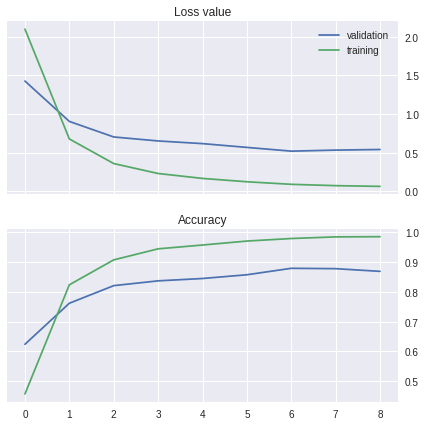

In [ ]:
plt.style.use('seaborn')                   
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   


plt.figure()
plt.subplot(211)
plt.plot(records.history['val_loss'], label="validation")
plt.plot(records.history['loss'],label="training")
plt.title('Loss value',fontsize=12)

ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records.history['val_accuracy'],label="validation")
plt.plot(records.history['accuracy'],label="training")
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

---------------------------

------------------------

# Test on unseen data

### Prepare data generator for testing

In [ ]:

batch_num = 3410

test_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=0.4,
#     horizontal_flip=True,
    preprocessing_function=inception_v3.preprocess_input)


X_test_gen = test_datagen.flow_from_directory('/content/drive/MyDrive/data/fruits-360/Testing40',
                                             target_size=(img_height, img_width),
                                             batch_size=batch_num, shuffle=False)

# not using y labels
batch_test = next(X_test_gen)
X_test = batch_test[0]
y_test = batch_test[1]

X_test.shape, y_test.shape

Found 3410 images belonging to 40 classes.


((3410, 100, 100, 3), (3410, 40))

In [ ]:
y_test[:3]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Model Testing

In [ ]:
# Predictions

# feed the images directly to the combined model
pred = combined_model.predict(X_test)

# convert from probabilities to labels
pred_label_index = pred.argmax(axis=1) 

In [ ]:
# Reference
# labels: ['Apple Braeburn', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit',
#          'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow',
#          'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig',
#          'Ginger Root', 'Granadilla', 'Grape Blue', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi']

In [ ]:
truth = y_test.argmax(axis=1) 

index = 1
print('actual', labels[truth[index]], 'predicted', labels[pred_label_index[index]])

actual Apple Braeburn predicted Apple Braeburn


In [ ]:
truth = y_test.argmax(axis=1) 
truth.shape

(3410,)

In [ ]:
print(confusion_matrix(truth, pred_label_index))
print(classification_report(truth, pred_label_index, target_names=labels))

[[79  0  0 ...  0  0  0]
 [ 4 74  0 ...  2  0  0]
 [ 0  0 70 ...  0  0  0]
 ...
 [ 0  0  0 ... 77  0  0]
 [ 0  0  0 ...  0 77  0]
 [ 0  0  0 ...  0  0 63]]
                    precision    recall  f1-score   support

    Apple Braeburn       0.95      0.96      0.96        82
           Apricot       0.81      0.90      0.86        82
           Avocado       0.99      1.00      0.99        70
      Avocado ripe       0.70      0.92      0.79        83
            Banana       0.65      0.72      0.68        83
Banana Lady Finger       0.81      0.76      0.78        76
        Banana Red       0.81      0.42      0.56        83
          Beetroot       0.91      0.52      0.66        75
         Blueberry       0.88      0.64      0.74        77
      Cactus fruit       0.51      1.00      0.67        83
      Cantaloupe 1       0.96      0.93      0.94        82
      Cantaloupe 2       0.93      0.96      0.95        82
         Carambula       0.95      0.42      0.58        83
   

In [ ]:
combined_model.save("inceptionv3_model.h5")

------------------------------------

-----------------------------